In [47]:
import json
import math
import base64
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from celluloid import Camera
from IPython.display import Image
from IPython.display import HTML

BAYES_QUARTILE_OPT = 0.25
RATES = [1,2,3,4,5]
index = 0
asinToIndex = {}
scoreMatrix = []
booksAsin = []
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=100000, #500000
    typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
)

nbChunks = 1 # <= 0 to load all chunks, positive integer to load specific number of chunks
for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    nbChunks -= 1
    if (nbChunks == 0):
        break

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(scoreMatrix):
    nbRating = np.sum(scoreMatrix, axis=1)
    avgRatings = (np.average(scoreMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(scoreMatrix, nbRating)
    stdRatings = np.std(scoreMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    return pd.DataFrame(
        data=np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings, nbNonAppreciate, nbNeutral, nbAppreciate, realClass)),
        index=booksAsin, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "Class"]
    )


scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in RATES]
)
display(pdScoreMat)

pdBooksFeatures = getBookStats(scoreMatrix)
display(pdBooksFeatures)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations"]

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
0060534095,0,0,0,1,4
0060534214,5,5,4,19,22
0060534249,2,2,5,12,17
0060534389,1,3,9,30,23


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,Class
000100039X,206.0,4.674757,4.659002,5.0,66.004242,10.0,8.0,188.0,2.0
0001055178,18.0,3.555556,3.734699,4.0,3.440930,4.0,2.0,12.0,2.0
0001473123,16.0,4.625000,4.494238,5.0,4.955805,1.0,0.0,15.0,2.0
0001473727,7.0,5.000000,4.597677,5.0,2.800000,0.0,0.0,7.0,2.0
0001473905,6.0,4.666667,4.412883,5.0,1.939072,0.0,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...
0060534095,5.0,4.800000,4.447290,5.0,1.549193,0.0,0.0,5.0,2.0
0060534214,55.0,3.872727,3.909153,4.0,7.823043,10.0,4.0,41.0,2.0
0060534249,38.0,4.052632,4.074833,4.0,5.953150,4.0,5.0,29.0,2.0
0060534389,66.0,4.075758,4.087226,4.0,11.391225,4.0,9.0,53.0,2.0


In [48]:
booksFeatures = pdBooksFeatures[CRITERIAS].to_numpy()
NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

# K means (Euclidean)
kmeansEucli = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(booksFeatures)
print("K-means Euclidean:")
display(pd.DataFrame(
    data=np.array([ [f"C{i+1}" for i in kmeansEucli.labels_] ]),
    index=["Class"],
    columns=booksAsin
))
display(pd.DataFrame(
    data=np.array([[np.count_nonzero(kmeansEucli.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
    index=["Number of Classes"],
    columns=CLASSES
))

# K-means (Cosine similiarity)
kmeansCos = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(preprocessing.normalize(booksFeatures))
print("K-means Cosine similiarity:")
display(pd.DataFrame(
    data=np.array([ [f"C{i+1}" for i in kmeansCos.labels_] ]),
    index=["Class"],
    columns=booksAsin
))
display(pd.DataFrame(
    data=np.array([[np.count_nonzero(kmeansCos.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
    index=["Number of Classes"],
    columns=CLASSES
))

K-means Euclidean:


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0060533226,0060533390,0060533455,0060533994,0060534044,0060534095,0060534214,0060534249,0060534389,0060534397
Class,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1


,C1,C2,C3
Number of Classes,2612,4,25


K-means Cosine similiarity:


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0060533226,0060533390,0060533455,0060533994,0060534044,0060534095,0060534214,0060534249,0060534389,0060534397
Class,C1,C1,C3,C2,C2,C3,C3,C2,C3,C2,...,C1,C3,C2,C1,C1,C2,C1,C1,C1,C1


,C1,C2,C3
Number of Classes,919,901,821


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations
000100039X,1.063049,0.915953,1.412028,0.736944,1.717776,0.250935,0.202767,1.268369
0001055178,-0.125594,-1.222406,-1.393247,-0.749893,-0.128770,0.007839,-0.113074,-0.143692
0001473123,-0.138240,0.820886,0.911966,0.736944,-0.084059,-0.113708,-0.218354,-0.119623
0001473727,-0.195143,1.537365,1.225905,0.736944,-0.147687,-0.154224,-0.218354,-0.183808
0001473905,-0.201465,0.900495,0.665052,0.736944,-0.173097,-0.154224,-0.165714,-0.199854
...,...,...,...,...,...,...,...,...
0060534095,-0.207788,1.155243,0.769477,0.736944,-0.184605,-0.154224,-0.218354,-0.199854
0060534214,0.108341,-0.616414,-0.863777,-0.749893,0.000567,0.250935,-0.007793,0.088977
0060534249,0.000857,-0.272687,-0.360936,-0.749893,-0.054622,0.007839,0.044847,-0.007300
0060534389,0.177889,-0.228502,-0.323323,-0.749893,0.105881,0.007839,0.255408,0.185254


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Nb rating,0.484469,-0.029300,-0.103282,-0.003300,0.020435,-0.007504,-0.388326,7.761976e-01
Average Rating,-0.018145,-0.583059,0.100174,0.373497,0.097906,0.707323,-0.016976,6.661338e-16
Bayes Rating,-0.019834,-0.582848,0.011913,0.417790,-0.109156,-0.687668,0.020059,-8.619407e-16
Median,-0.003480,-0.546561,0.141233,-0.824350,0.017030,-0.037506,0.007960,1.370432e-16
STD,0.426760,-0.087318,-0.543205,-0.039402,-0.240856,0.086112,0.669478,-3.219647e-15
Depreciation,0.399897,0.082204,0.642553,0.038771,-0.631832,0.055085,0.045049,-1.211269e-01
Neutral,0.452538,0.051096,0.387947,0.054114,0.720323,-0.122030,0.310998,-9.322844e-02
Appreciations,0.466609,-0.061247,-0.317429,-0.020112,0.041261,-0.001831,-0.549090,-6.116813e-01


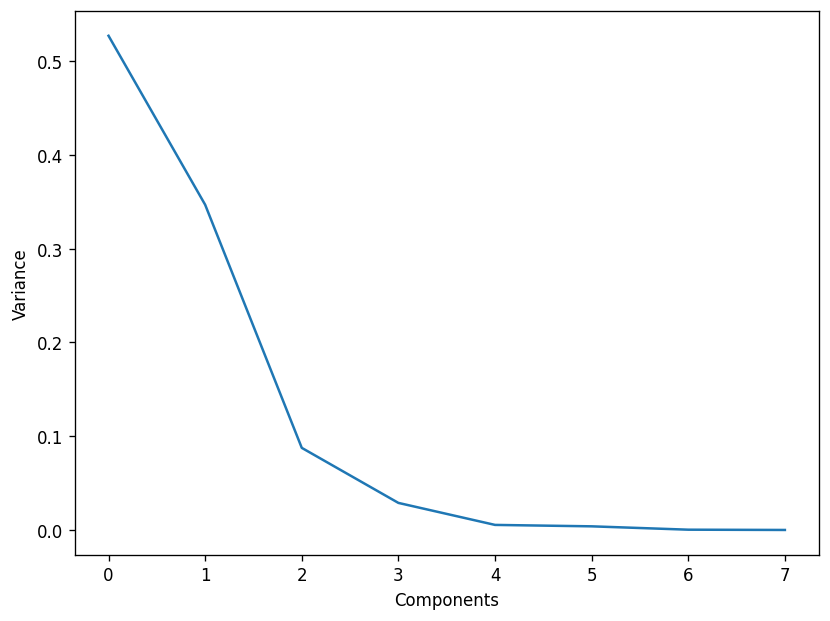

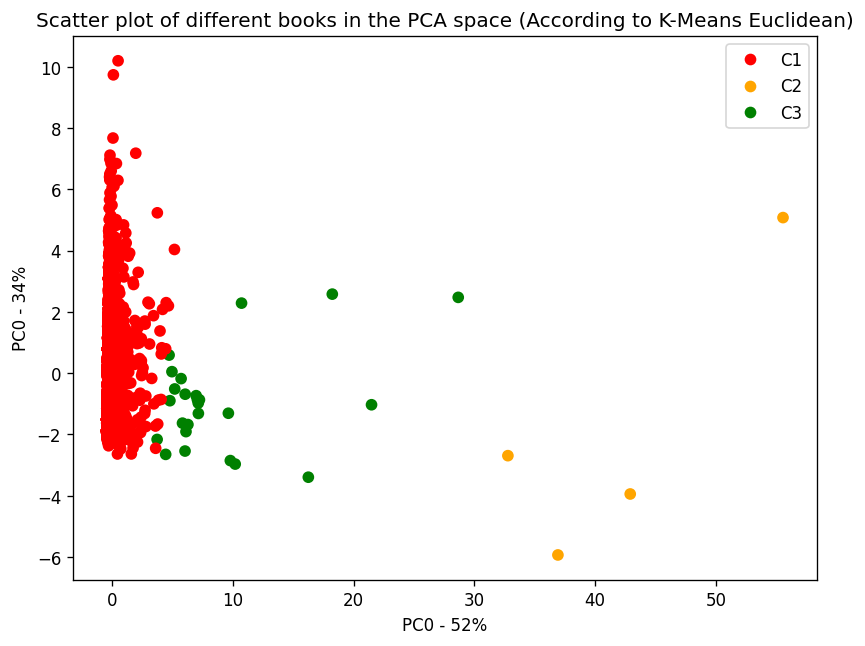

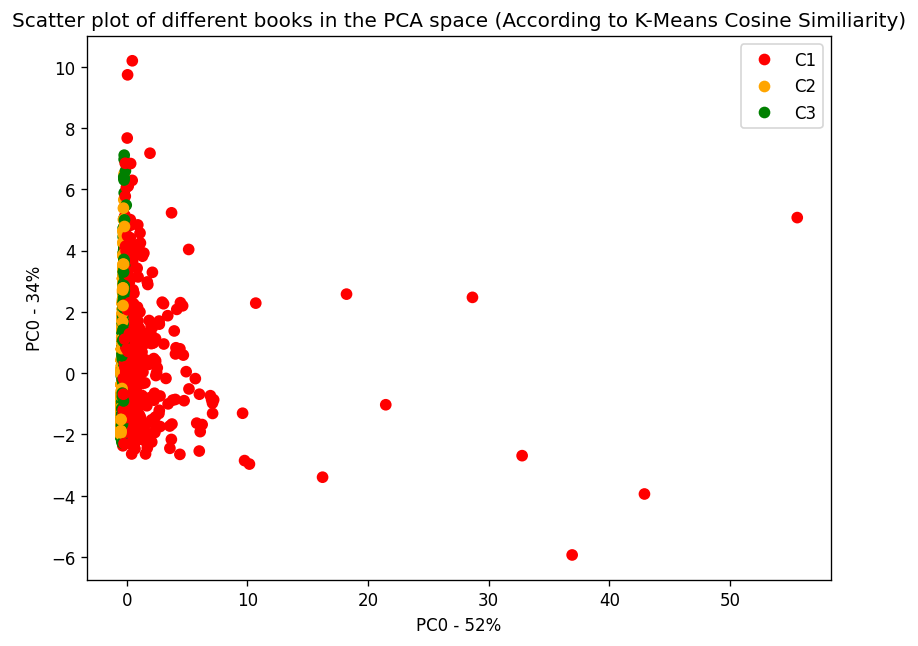

In [49]:
# Data Normalization
pdBooksFeaturesNormalized = (pdBooksFeatures[CRITERIAS] - pdBooksFeatures[CRITERIAS].mean()) / pdBooksFeatures[CRITERIAS].std()
display(pdBooksFeaturesNormalized)

# PCA Calculations
pca = PCA(n_components=pdBooksFeaturesNormalized.shape[1])
pca.fit(pdBooksFeaturesNormalized)

# PCA Results
booksFeaturesPCA = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))],
    index=pdBooksFeaturesNormalized.columns
)

display(booksFeaturesPCA)
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Variance")
plt.xlabel("Components")
plt.show()

# Plot PCA (2 major axis)
booksFeatures2PCA = pd.DataFrame(
    data=pca.transform(pdBooksFeaturesNormalized), 
    columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))]
)

def scatterPlotHelper(dataXY, dataLabels, title="", axisLabel=[]):
    plt.figure(figsize=(8,6), dpi=120)
    if (axisLabel != []):
        plt.xlabel(axisLabel[0])
        plt.ylabel(axisLabel[1])
    scatter = plt.scatter(x=dataXY[0], y=dataXY[1], c=dataLabels, cmap=colors)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
    plt.title(title)
    plt.show()

scatterPlotHelper(
    dataXY=(booksFeatures2PCA["PC0"], booksFeatures2PCA["PC1"]), 
    dataLabels=kmeansEucli.labels_, 
    title="Scatter plot of different books in the PCA space (According to K-Means Euclidean)",
    axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC0 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
)
scatterPlotHelper(
    dataXY=(booksFeatures2PCA["PC0"], booksFeatures2PCA["PC1"]), 
    dataLabels=kmeansCos.labels_, 
    title="Scatter plot of different books in the PCA space (According to K-Means Cosine Similiarity)",
    axisLabel=[f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC0 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
)

# Q3 : Interprétation des résultats visuelles
TODO

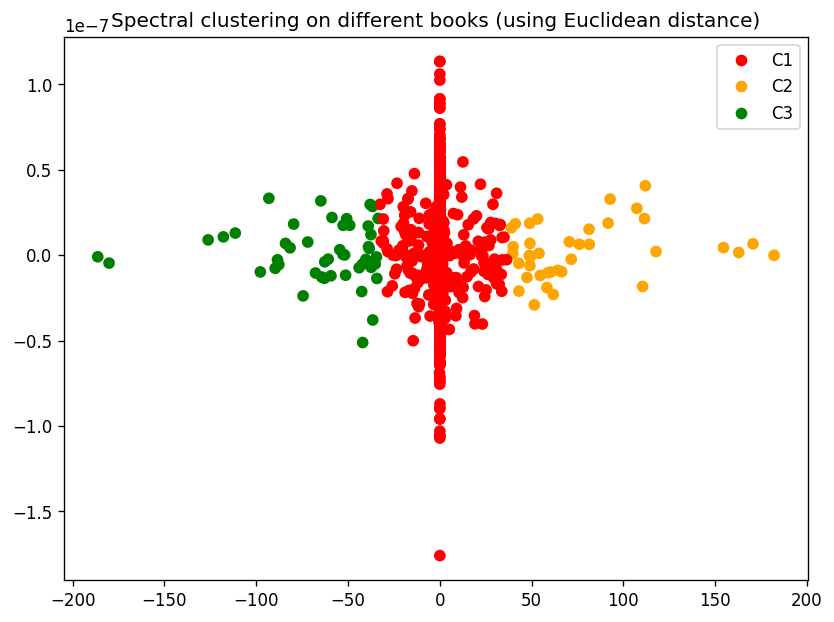

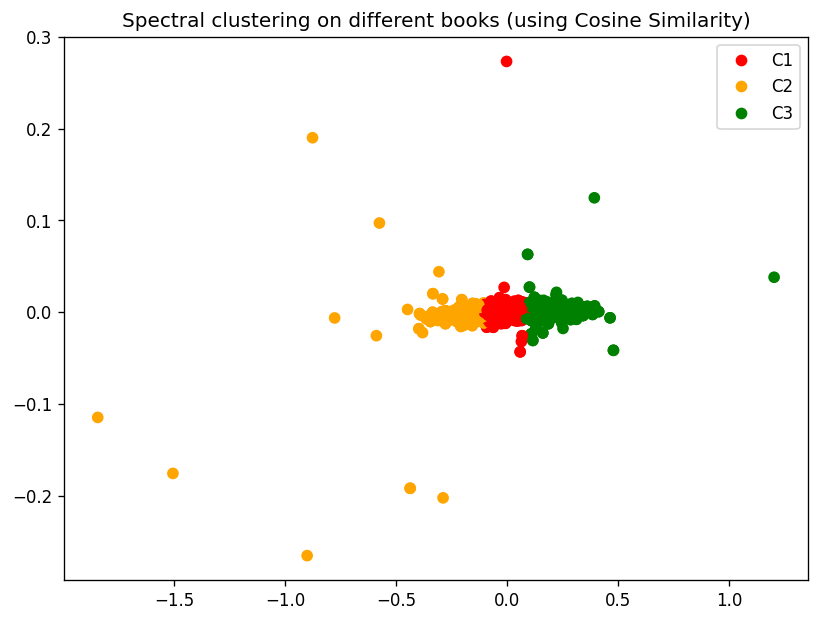

In [50]:
# Q4
eucli = lambda x, y: np.linalg.norm(x-y)
cosSim = lambda x, y: (x @ y.T) / (np.linalg.norm(x) * np.linalg.norm(y))

def spectralClustering(booksData, distFunc):
    funcMap = {"euclidean": eucli, "cosine": cosSim}
    booksFeaturesData = booksData.to_numpy()
    N = booksFeaturesData.shape[0]
    """M = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            M[i,j] = funcMap[distFunc](booksFeaturesData[i,:], booksFeaturesData[j,:])"""
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(booksFeaturesData), distFunc))
    if (distFunc == "cosine"): M = 1 - M
    # assert (M.shape == M2.shape and np.allclose(M, M2))
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    evals, evecs = [], []
    for i in idx:
        if (eigenValues[i].real >= 0):
            evals.append(eigenValues[i].real)
            evecs.append(eigenVectors[i,:].real)
        else: break
    P = np.stack(evecs)
    D = np.diag(evals)
    spectralDataMat = P.T @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans

eucliCoords, spectralEucli = spectralClustering(pdBooksFeatures[CRITERIAS], "euclidean")
cosCoords, spectralCos =  spectralClustering(pdBooksFeatures[CRITERIAS], "cosine")

scatterPlotHelper(
    dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
    dataLabels=spectralEucli.labels_, 
    title="Spectral clustering on different books (using Euclidean distance)"
)
scatterPlotHelper(
    dataXY=(cosCoords[:,0],cosCoords[:,1]), 
    dataLabels=spectralCos.labels_, 
    title="Spectral clustering on different books (using Cosine Similarity)"
)

In [61]:
# Q5
bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
perfMetric = np.array([
    [
        sk.metrics.silhouette_score(booksFeatures, kmeansEucli.labels_), 
        sk.metrics.adjusted_mutual_info_score(kmeansEucli.labels_, bookClasses), 
        sk.metrics.silhouette_score(booksFeatures, kmeansCos.labels_), 
        sk.metrics.adjusted_mutual_info_score(kmeansCos.labels_, bookClasses), 
    ],
    [
        sk.metrics.silhouette_score(booksFeatures, spectralEucli.labels_), 
        sk.metrics.adjusted_mutual_info_score(spectralEucli.labels_, bookClasses), 
        sk.metrics.silhouette_score(booksFeatures, spectralCos.labels_), 
        sk.metrics.adjusted_mutual_info_score(spectralCos.labels_, bookClasses), 
    ],
])

display(pd.DataFrame(
    data=perfMetric, 
    columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
    index=["K-means", "Spectral"]
))

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.945989,-0.000028,0.088325,0.008281
Spectral,0.516746,0.000129,0.050893,-0.000556


# b / 1
1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?
